## Imports

In [13]:
# !pip install pandas scikit-learn 
# !pip install tqdm
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# Imports and Device Setup
import os
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
import torch
print(torch.cuda.device_count())      
print(torch.cuda.get_device_name(0)) 

4
Tesla V100-DGXS-32GB


## Load Dataset

In [9]:
class VisionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'img']   # use 'img' column which contains full path
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.df.loc[idx, 'label']
        return image, label

In [10]:
# Load Data, Split, and Prepare Dataloaders

data_path = "Final_updated_data.json"
image_dir = "Dataset/images"

# Load JSON and shuffle
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

random.shuffle(data)
df = pd.DataFrame(data)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1491, Val: 320, Test: 320


In [11]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = VisionDataset(train_df, transform=transform)
val_dataset = VisionDataset(val_df, transform=transform)
test_dataset = VisionDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = df['label'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 2


## Exploratory Data Analysis

In [12]:
train_df[0:5]

,id,img,label,text
562,hate_632,/home/yuvakumar/Desktop/Telugu_memes_classifie...,1,కసిరాజా హారు మీలే kasi raja hot stories అంకులే...
2117,hate_976,/home/yuvakumar/Desktop/Telugu_memes_classifie...,1,when you got banged by him multiple times expe...
1658,NonHate_180,/home/yuvakumar/Desktop/Telugu_memes_classifie...,0,
1277,hate_414,/home/yuvakumar/Desktop/Telugu_memes_classifie...,1,
1546,hate_315,/home/yuvakumar/Desktop/Telugu_memes_classifie...,1,enti aligava ninna mga chikaledu ani ninna ma ...


/tmp/ipykernel_24642/1106623517.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette=['#1f77b4', '#ff7f0e'])  # Two different colors


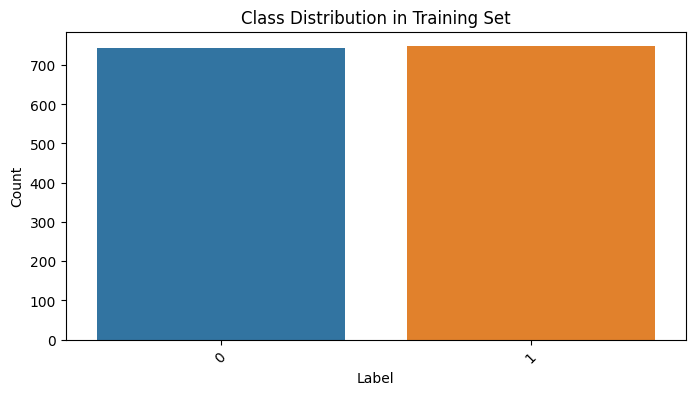

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='label', palette=['#1f77b4', '#ff7f0e'])  # Two different colors
plt.title('Class Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
print("Train class distribution:\n", train_df['label'].value_counts())
print("Validation class distribution:\n", val_df['label'].value_counts())
print("Test class distribution:\n", test_df['label'].value_counts())

Train class distribution:
 label
1    748
0    743
Name: count, dtype: int64
Validation class distribution:
 label
1    161
0    159
Name: count, dtype: int64
Test class distribution:
 label
0    160
1    160
Name: count, dtype: int64


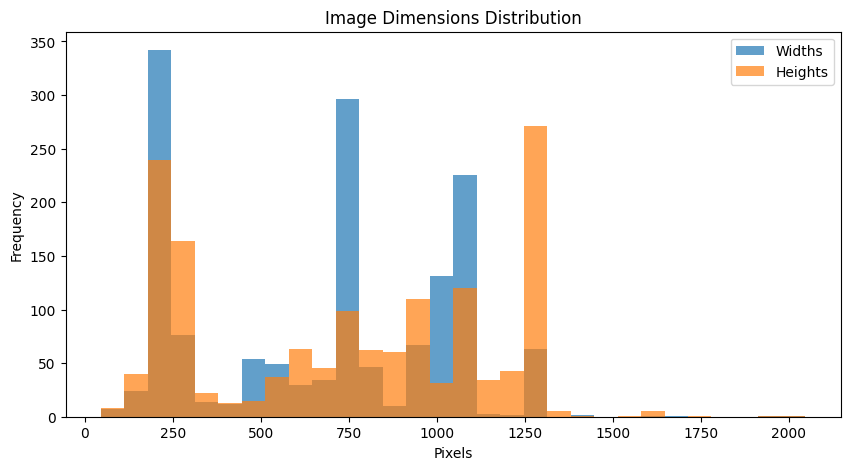

In [18]:
from PIL import Image
import numpy as np

sizes = [Image.open(p).size for p in train_df['img']]
widths, heights = zip(*sizes)

plt.figure(figsize=(10, 5))
plt.hist(widths, bins=30, alpha=0.7, label='Widths')
plt.hist(heights, bins=30, alpha=0.7, label='Heights')
plt.title('Image Dimensions Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [19]:
def check_corrupt_images(df):
    corrupt = []
    for path in df['img']:
        try:
            img = Image.open(path)
            img.verify()
        except Exception:
            corrupt.append(path)
    return corrupt

corrupt_images = check_corrupt_images(train_df)
print(f"Number of corrupt images: {len(corrupt_images)}")


Number of corrupt images: 0


## Load Model

In [20]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

def get_resnet50_model(num_classes):
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_efficientnet_b7_model(num_classes):
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def get_vit_b16_model(num_classes):
    weights = ViT_B_16_Weights.DEFAULT
    model = vit_b_16(weights=weights)
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

## Train Model

In [21]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

In [22]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
        
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
    
    print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(torch.load("best_model.pth"))
    return model, (train_losses, val_losses, train_accs, val_accs)


In [26]:
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

## 1. ResNet50

In [23]:
num_epochs = 6
results = {}

print("\n===== Training ResNet50 =====")
model_resnet = get_resnet50_model(num_classes)
model_resnet, history_resnet = train_model(model_resnet, train_loader, val_loader, num_epochs=num_epochs)


===== Training ResNet50 =====


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/yuvakumar/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%



Epoch 1/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.00it/s]


Train Loss: 0.4634, Acc: 0.7975
Val   Loss: 0.3095, Acc: 0.8719

Epoch 2/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.14it/s]


Train Loss: 0.1544, Acc: 0.9463
Val   Loss: 0.3264, Acc: 0.8813

Epoch 3/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.95it/s]


Train Loss: 0.0480, Acc: 0.9926
Val   Loss: 0.3673, Acc: 0.8813

Epoch 4/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.08it/s]


Train Loss: 0.0201, Acc: 0.9987
Val   Loss: 0.3494, Acc: 0.8781

Epoch 5/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.87it/s]


Train Loss: 0.0154, Acc: 0.9980
Val   Loss: 0.4263, Acc: 0.8875

Epoch 6/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.94it/s]


Train Loss: 0.0094, Acc: 0.9993
Val   Loss: 0.4297, Acc: 0.8844

Best Validation Accuracy: 0.8875


In [24]:
# Evaluate on test set
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = eval_one_epoch(model_resnet, test_loader, criterion, device)
results['ResNet50'] = {'test_acc': test_acc, 'history': history_resnet}
print(f"ResNet50 Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.92it/s]

ResNet50 Test Accuracy: 0.8875


In [25]:
# Define path to save the model
save_path = './models/resnet50_best_model.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dict
torch.save(model_resnet.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ./models/resnet50_best_model.pth


### Test on Sample images

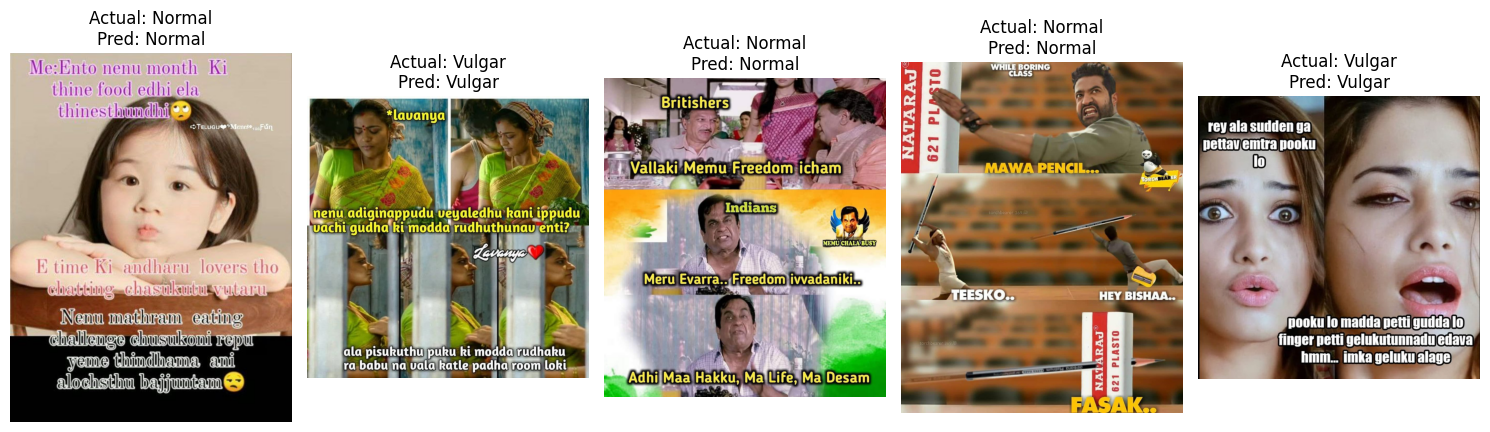

In [34]:
import random

label_map = {0: 'Normal', 1: 'Vulgar'}

# Pick 5 random samples from test_df
sample_df = test_df.sample(n=5, random_state=random.randint(0, 1000)).reset_index(drop=True)

plt.figure(figsize=(15, 8))

for i, row in sample_df.iterrows():
    img_path = row['img']  # Adjust column name if necessary
    actual_label = label_map[row['label']]

    # Predict class
    pred_label_idx = predict_image(img_path, model_resnet, transform, device)
    pred_label = label_map[pred_label_idx]

    # Load and show image
    img = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()

## 2. EfficientNet-B7

### Train

In [35]:
print("\n===== Training EfficientNet-B7 =====")
model_effnet = get_efficientnet_b7_model(num_classes)
model_effnet, history_effnet = train_model(model_effnet, train_loader, val_loader, num_epochs=num_epochs)

test_loss, test_acc = eval_one_epoch(model_effnet, test_loader, criterion, device)
results['EfficientNet-B7'] = {'test_acc': test_acc, 'history': history_effnet}
print(f"EfficientNet-B7 Test Accuracy: {test_acc:.4f}")


===== Training EfficientNet-B7 =====


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /home/yuvakumar/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100.0%



Epoch 1/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


Train Loss: 0.5045, Acc: 0.7720
Val   Loss: 0.4883, Acc: 0.7781

Epoch 2/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.29it/s]


Train Loss: 0.1992, Acc: 0.9329
Val   Loss: 0.3856, Acc: 0.8438

Epoch 3/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.25it/s]


Train Loss: 0.0666, Acc: 0.9839
Val   Loss: 0.5009, Acc: 0.8313

Epoch 4/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


Train Loss: 0.0243, Acc: 0.9960
Val   Loss: 0.5626, Acc: 0.8500

Epoch 5/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.26it/s]


Train Loss: 0.0132, Acc: 0.9966
Val   Loss: 0.5940, Acc: 0.8656

Epoch 6/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


Train Loss: 0.0209, Acc: 0.9946
Val   Loss: 0.6003, Acc: 0.8625

Best Validation Accuracy: 0.8656


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]

EfficientNet-B7 Test Accuracy: 0.8594


### test

In [61]:
# Evaluate on test set
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = eval_one_epoch(model_resnet, test_loader, criterion, device)
results['EfficientNet-B7'] = {'test_acc': test_acc, 'history': history_resnet}
print(f"EfficientNet-B7 Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.62it/s]

EfficientNet-B7 Test Accuracy: 0.8875


In [38]:
# Define path to save the model
save_path = './models/EfficientNetb7_model.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dict
torch.save(model_resnet.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ./models/EfficientNetb7_model.pth


### Test on Sample Images

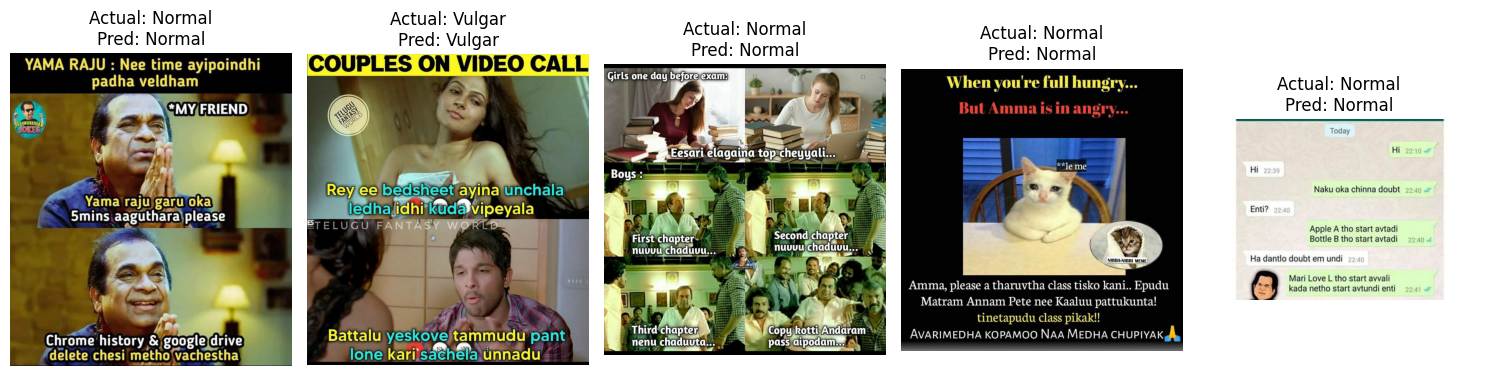

In [40]:
import random

label_map = {0: 'Normal', 1: 'Vulgar'}

# Pick 5 random samples from test_df
sample_df = test_df.sample(n=5, random_state=random.randint(0, 1000)).reset_index(drop=True)

plt.figure(figsize=(15, 8))

for i, row in sample_df.iterrows():
    img_path = row['img']  # Adjust column name if necessary
    actual_label = label_map[row['label']]

    # Predict class
    pred_label_idx = predict_image(img_path, model_effnet, transform, device)
    pred_label = label_map[pred_label_idx]

    # Load and show image
    img = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()

## 3. ViT-B_16

### train

In [36]:
print("\n===== Training ViT-B_16 =====")
model_vit = get_vit_b16_model(num_classes)
model_vit, history_vit = train_model(model_vit, train_loader, val_loader, num_epochs=num_epochs)

test_loss, test_acc = eval_one_epoch(model_vit, test_loader, criterion, device)
results['ViT-B_16'] = {'test_acc': test_acc, 'history': history_vit}
print(f"ViT-B_16 Test Accuracy: {test_acc:.4f}")



===== Training ViT-B_16 =====


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/yuvakumar/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100.0%



Epoch 1/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]


Train Loss: 0.4407, Acc: 0.7968
Val   Loss: 0.4358, Acc: 0.8688

Epoch 2/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.27it/s]


Train Loss: 0.1513, Acc: 0.9457
Val   Loss: 0.3915, Acc: 0.8594

Epoch 3/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.24it/s]


Train Loss: 0.0512, Acc: 0.9846
Val   Loss: 0.4410, Acc: 0.8625

Epoch 4/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.24it/s]


Train Loss: 0.0437, Acc: 0.9866
Val   Loss: 0.4010, Acc: 0.8781

Epoch 5/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.26it/s]


Train Loss: 0.0907, Acc: 0.9678
Val   Loss: 0.4753, Acc: 0.8594

Epoch 6/6


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.24it/s]


Train Loss: 0.0665, Acc: 0.9745
Val   Loss: 0.3887, Acc: 0.8875

Best Validation Accuracy: 0.8875


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]

ViT-B_16 Test Accuracy: 0.8344


### test 

In [62]:
# Evaluate on test set
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = eval_one_epoch(model_resnet, test_loader, criterion, device)
results['ViT-B_16'] = {'test_acc': test_acc, 'history': history_resnet}
print(f"ViT-B_16 Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.62it/s]

ViT-B_16 Test Accuracy: 0.8875


In [42]:
# Define path to save the model
save_path = './models/ViT_B_16.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dict
torch.save(model_resnet.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ./models/ViT_B_16.pth


### test on Sample Images

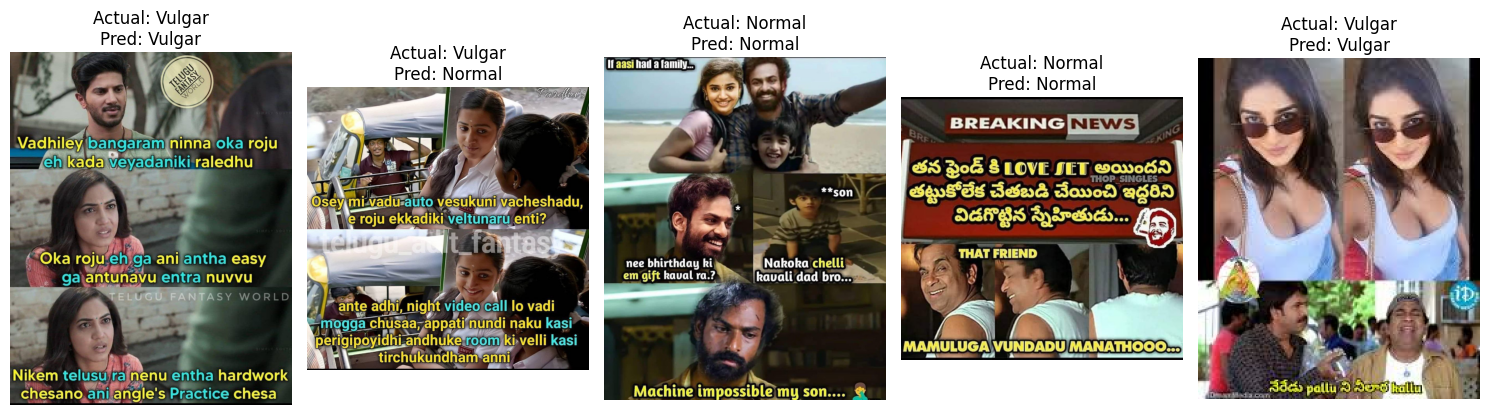

In [43]:
import random

label_map = {0: 'Normal', 1: 'Vulgar'}

# Pick 5 random samples from test_df
sample_df = test_df.sample(n=5, random_state=random.randint(0, 1000)).reset_index(drop=True)

plt.figure(figsize=(15, 8))

for i, row in sample_df.iterrows():
    img_path = row['img']  # Adjust column name if necessary
    actual_label = label_map[row['label']]

    # Predict class
    pred_label_idx = predict_image(img_path, model_vit, transform, device)
    pred_label = label_map[pred_label_idx]

    # Load and show image
    img = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()

## Visualization

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F

def get_predictions_and_probs(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

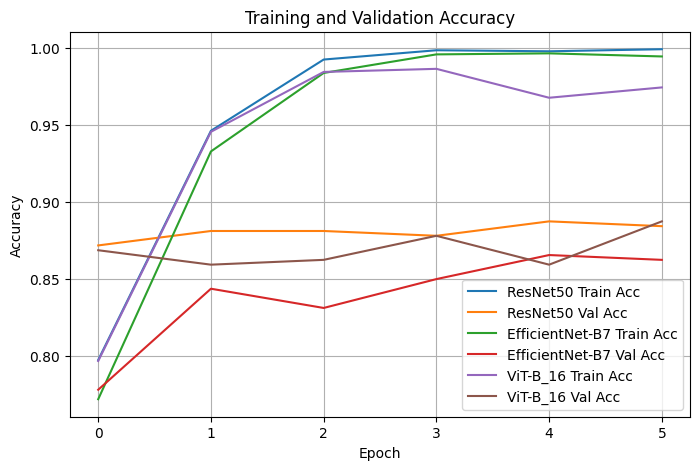

In [64]:
# Cell 5a: Plot accuracy curves separately

def plot_accuracy_curves(histories, model_names):
    plt.figure(figsize=(8,5))
    for history, name in zip(histories, model_names):
        train_acc = history[2]  # train_accs
        val_acc = history[3]    # val_accs
        plt.plot(train_acc, label=f'{name} Train Acc')
        plt.plot(val_acc, label=f'{name} Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_curves(histories, model_names)

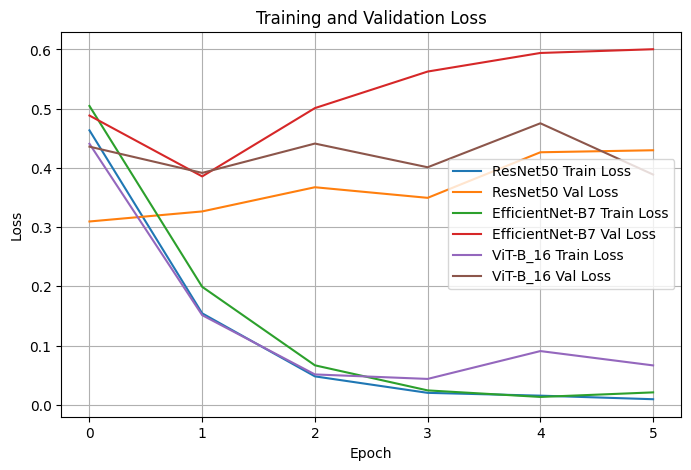

In [65]:
# Cell 5b: Plot loss curves separately

def plot_loss_curves(histories, model_names):
    plt.figure(figsize=(8,5))
    for history, name in zip(histories, model_names):
        train_loss = history[0]  # train_losses
        val_loss = history[1]    # val_losses
        plt.plot(train_loss, label=f'{name} Train Loss')
        plt.plot(val_loss, label=f'{name} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(histories, model_names)


In [46]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

In [66]:
def plot_roc_curve(y_true, y_probs, n_classes=2, title='ROC Curve'):
    # For binary classification, n_classes=2
    plt.figure(figsize=(8,6))
    
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_probs[:,1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    else:
        # One-vs-rest ROC for multi-class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [48]:
def print_classification_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes))

In [50]:
# Cell 1: Define classes and model lists
classes = ['NonHate', 'Vulgar']
n_classes = len(classes)

model_names = ['ResNet50', 'EfficientNet-B7', 'ViT-B_16']
histories = [history_resnet, history_effnet, history_vit]
models = [model_resnet, model_effnet, model_vit]

results_preds = {}
results_probs = {}


In [51]:
# Cell 2: Run predictions, save results, and print classification reports for each model
for model, name in zip(models, model_names):
    y_true, y_pred, y_probs = get_predictions_and_probs(model, test_loader, device)
    results_preds[name] = (y_true, y_pred)
    results_probs[name] = y_probs
    print(f"\nClassification Report for {name}:")
    print_classification_report(y_true, y_pred, classes)



Classification Report for ResNet50:
              precision    recall  f1-score   support

     NonHate       0.88      0.90      0.89       160
      Vulgar       0.90      0.88      0.89       160

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.89      0.89      0.89       320


Classification Report for EfficientNet-B7:
              precision    recall  f1-score   support

     NonHate       0.85      0.87      0.86       160
      Vulgar       0.87      0.85      0.86       160

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320


Classification Report for ViT-B_16:
              precision    recall  f1-score   support

     NonHate       0.82      0.85      0.84       160
      Vulgar       0.85      0.82      0.83       160

    accuracy                           0.83       320
   macro a

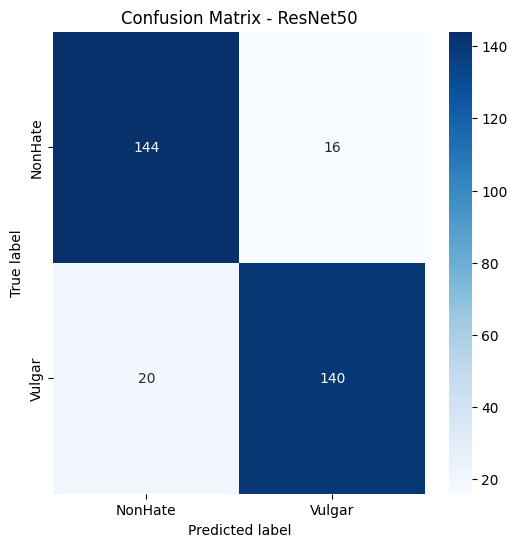

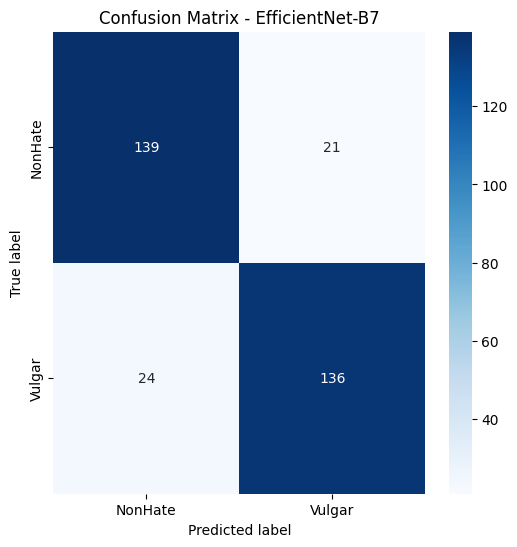

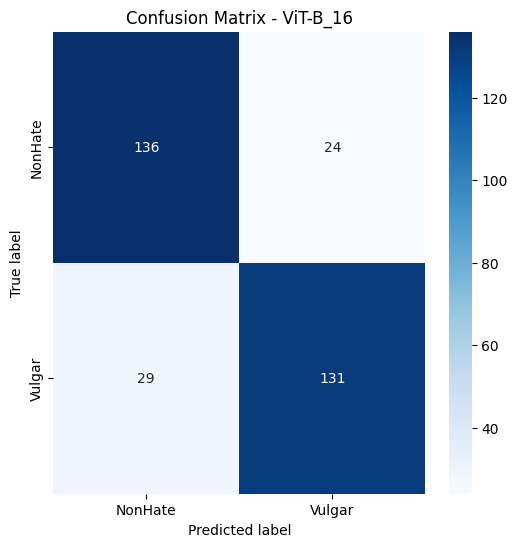

In [52]:
# Cell 3: Plot confusion matrices for each model
for name in model_names:
    y_true, y_pred = results_preds[name]
    plot_confusion_matrix(y_true, y_pred, classes, title=f'Confusion Matrix - {name}')


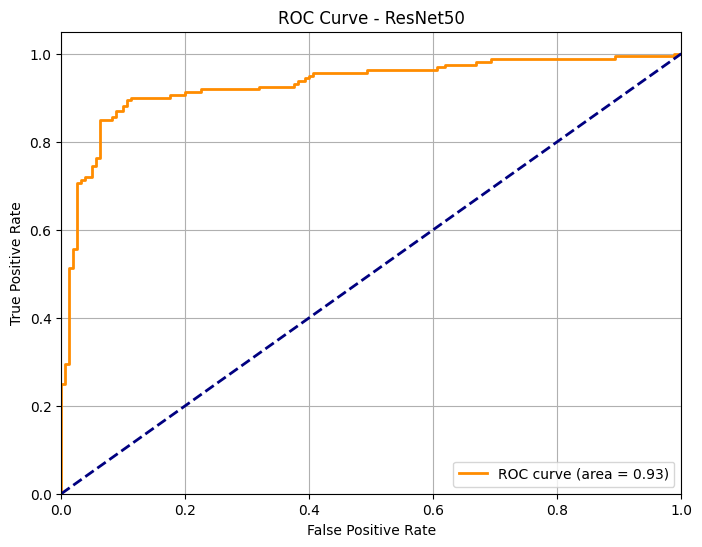

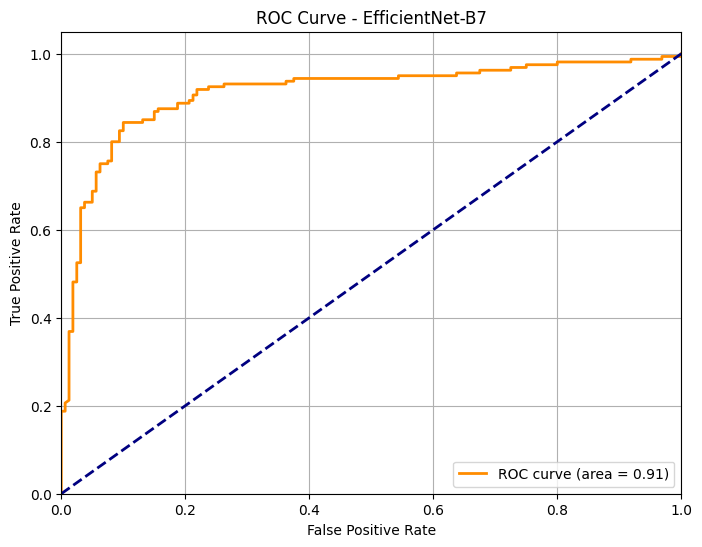

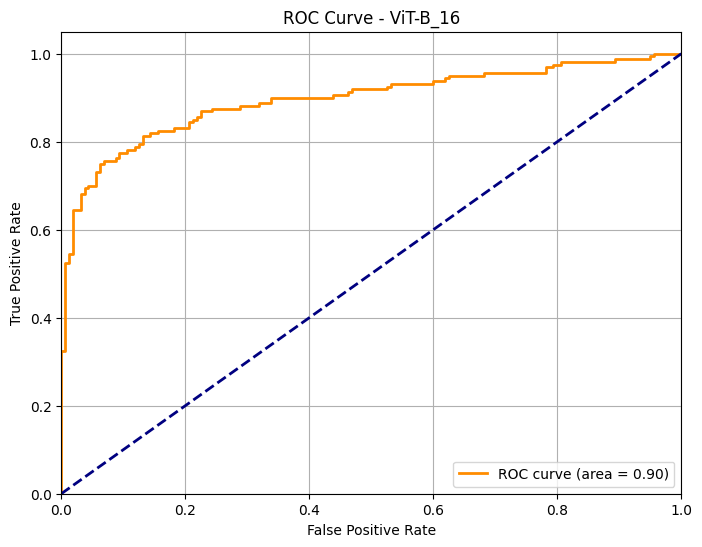

In [53]:
# Cell 4: Plot ROC curves for each model
for name in model_names:
    y_true = results_preds[name][0]
    y_probs = results_probs[name]
    plot_roc_curve(y_true, y_probs, n_classes=n_classes, title=f'ROC Curve - {name}')



Classification Report for ResNet50:
              precision    recall  f1-score   support

     NonHate       0.88      0.90      0.89       160
      Vulgar       0.90      0.88      0.89       160

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.89      0.89      0.89       320



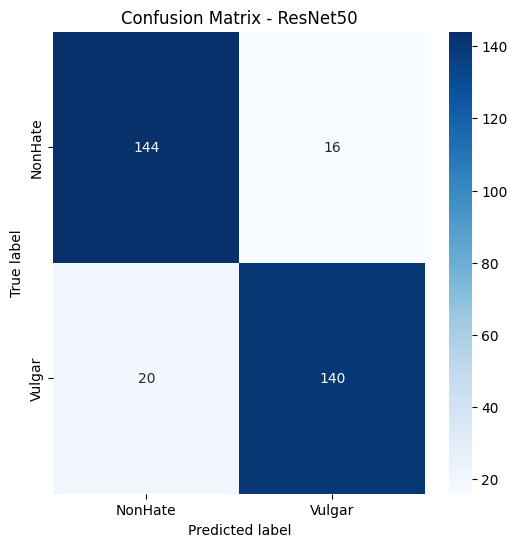

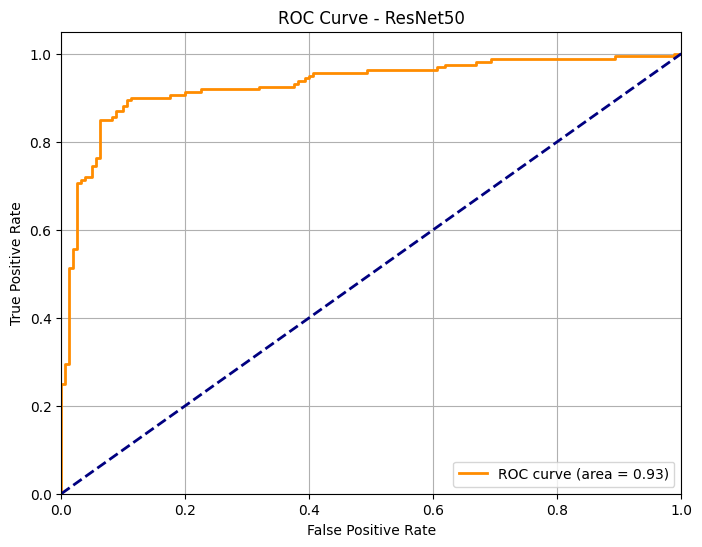


Classification Report for EfficientNet-B7:
              precision    recall  f1-score   support

     NonHate       0.85      0.87      0.86       160
      Vulgar       0.87      0.85      0.86       160

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



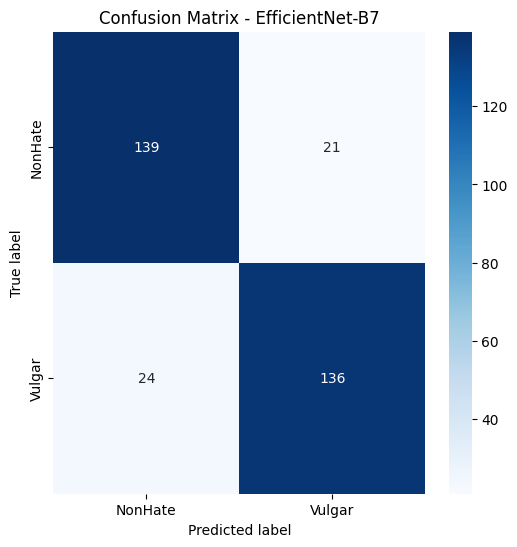

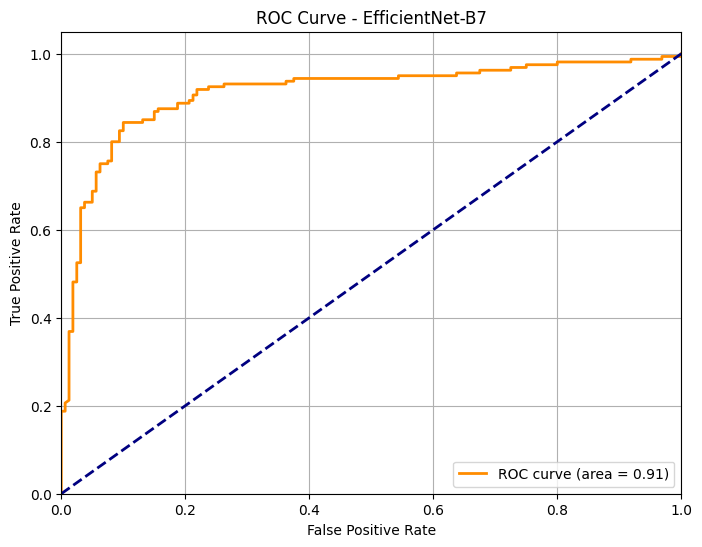


Classification Report for ViT-B_16:
              precision    recall  f1-score   support

     NonHate       0.82      0.85      0.84       160
      Vulgar       0.85      0.82      0.83       160

    accuracy                           0.83       320
   macro avg       0.83      0.83      0.83       320
weighted avg       0.83      0.83      0.83       320



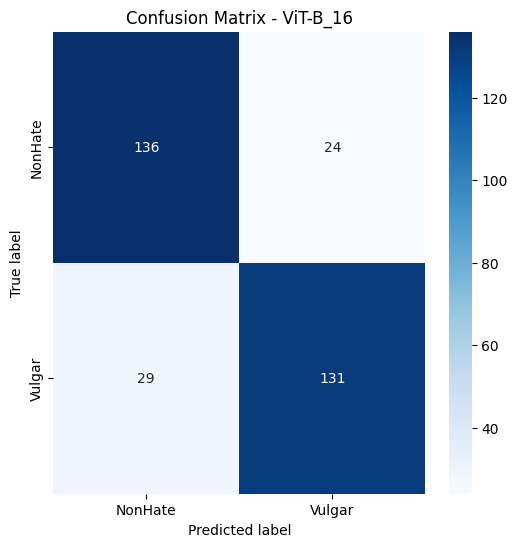

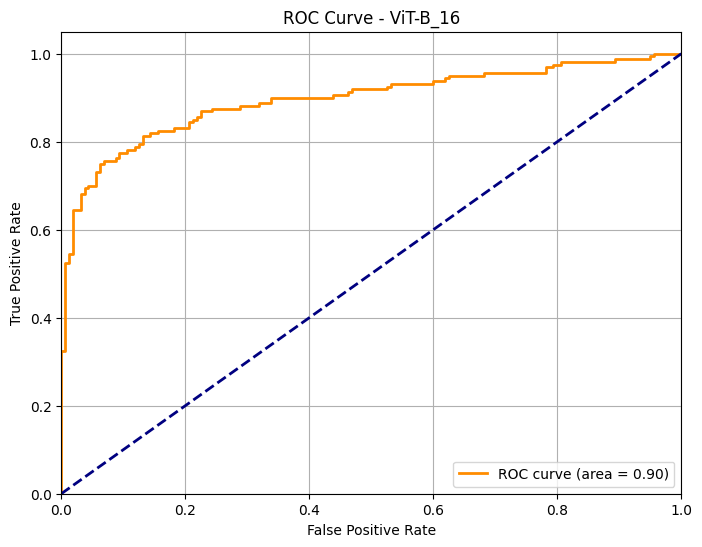

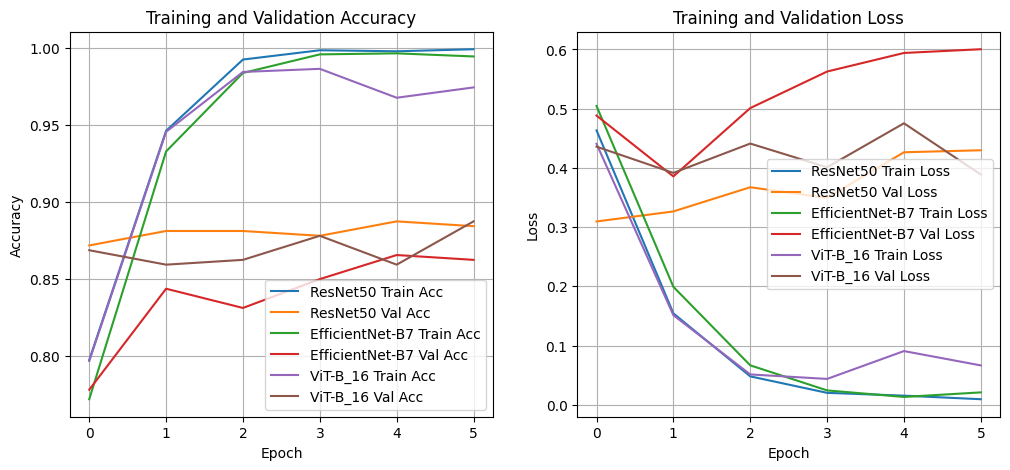

In [49]:
# Assuming your classes are 0: NonHate, 1: Hate
classes = ['NonHate', 'Vulgar']
n_classes = len(classes)

model_names = ['ResNet50', 'EfficientNet-B7', 'ViT-B_16']
histories = [history_resnet, history_effnet, history_vit]
models = [model_resnet, model_effnet, model_vit]

results_preds = {}
results_probs = {}

for model, name in zip(models, model_names):
    y_true, y_pred, y_probs = get_predictions_and_probs(model, test_loader, device)
    results_preds[name] = (y_true, y_pred)
    results_probs[name] = y_probs
    print(f"\nClassification Report for {name}:")
    print_classification_report(y_true, y_pred, classes)
    plot_confusion_matrix(y_true, y_pred, classes, title=f'Confusion Matrix - {name}')
    plot_roc_curve(y_true, y_probs, n_classes=n_classes, title=f'ROC Curve - {name}')

# Plot training & validation accuracy/loss curves side-by-side
plot_training_curves(histories, model_names)